In [34]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Dict
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from langchain_groq import ChatGroq

In [35]:
#Load api 
load_dotenv()

True

In [36]:
# Step 1: Define Schemas
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="Sentiment of the review")
    
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UI", "Performance", "Bug", "Support", "Other"]
    tone: Literal["Angry", "Frustrated", "Neutral"]
    urgency: Literal["Low", "Medium", "High"]

In [37]:
# Step 2: Models
structured_model = ChatGroq(
    model="deepseek-r1-distill-llama-70b", temperature=0
).with_structured_output(SentimentSchema)

structured_model2 = ChatGroq(
    model="deepseek-r1-distill-llama-70b", temperature=0
).with_structured_output(DiagnosisSchema)

normal_model = ChatGroq(model="deepseek-r1-distill-llama-70b", temperature=0)

In [38]:
# Step 3: Define State
class ReviewState(TypedDict):
    review: str
    sentiment: str
    diagnosis: Dict
    response: str

In [39]:
# Step 4: Functions (Nodes)
def find_sentiment(state: ReviewState):
    prompt = f"What is the sentiment of the following review?\n\n{state['review']}"
    output = structured_model.invoke(prompt)
    return {"sentiment": output.sentiment}

def positive_response(state: ReviewState):
    prompt = f"Write a warm thank-you reply for this positive review:\n\n{state['review']}"
    resp = normal_model.invoke(prompt)
    return {"response": resp.content}

def run_diagnosis(state: ReviewState):
    prompt = f"Diagnose this negative review:\n\n{state['review']}\nReturn issue_type, tone, urgency."
    output = structured_model2.invoke(prompt)
    return {"diagnosis": output.model_dump()}

def negative_response(state: ReviewState):
    diag = state["diagnosis"]
    prompt = f"""You are a support assistant. 
    The user reported an issue of type {diag['issue_type']}, with tone {diag['tone']} 
    and urgency {diag['urgency']}. Write an empathetic helpful reply."""
    resp = normal_model.invoke(prompt)
    return {"response": resp.content}

In [40]:
# Step 5: Routing Function
def check_sentiment(state: ReviewState) -> Literal["PositiveResponse","RunDiagnosis"]:
    if state["sentiment"] == "positive":
        return "PositiveResponse"
    else:
        return "RunDiagnosis"

In [41]:
# Step 6: Build Graph
graph = StateGraph(ReviewState)
graph.add_node("FindSentiment", find_sentiment)
graph.add_node("PositiveResponse", positive_response)
graph.add_node("RunDiagnosis", run_diagnosis)
graph.add_node("NegativeResponse", negative_response)

In [42]:
#edges
graph.add_edge(START, "FindSentiment")
graph.add_conditional_edges("FindSentiment", check_sentiment)
graph.add_edge("PositiveResponse", END)
graph.add_edge("RunDiagnosis", "NegativeResponse")
graph.add_edge("NegativeResponse", END)


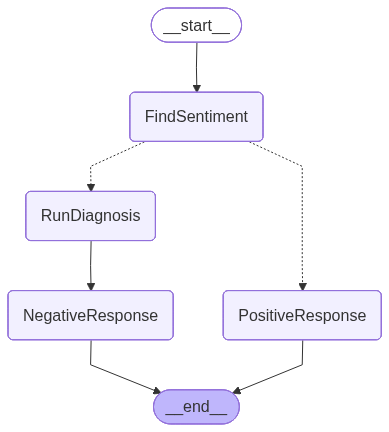

In [43]:
workflow = graph.compile()
workflow

In [44]:
# Step 7: Run
initial_state = {"review": "The product is too slow and keeps crashing."}
result = workflow.invoke(initial_state)

print("Review:", result["review"])
print("Sentiment:", result["sentiment"])
print("Diagnosis:", result.get("diagnosis"))
print("Response:", result["response"])

Review: The product is too slow and keeps crashing.
Sentiment: negative
Diagnosis: {'issue_type': 'Bug', 'tone': 'Frustrated', 'urgency': 'High'}
Response: <think>
Okay, I need to respond to a user who's frustrated and reported a high-urgency bug. First, I should acknowledge their frustration to show empathy. Then, I should apologize for the inconvenience. It's important to assure them that we're taking the issue seriously and will prioritize resolving it. I should ask for more details to help diagnose the problem faster. I'll keep the tone supportive and understanding to make them feel heard and valued.
</think>

I'm really sorry to hear you're experiencing this issue. I completely understand how frustrating that must be for you. Please know that we take this very seriously and are committed to resolving it as quickly as possible. Could you provide more details about the problem you're encountering? The more information you can share, the faster we can work to fix it. Thank you for yo